# Hopfiled networks

In [3]:
%matplotlib inline
from pylab import *
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml(name='mnist_784', as_frame = False)

In [224]:
# print(mnist.keys())
# print (mnist.target)

def to_mat(image_array):
    return image_array.reshape(28,28)

def show_example_plot(image_array, label=None):
    fig, ax = plt.subplots()
    ax.imshow(to_mat(image_array),cmap='Greys')
    if label != None:
        ax.set(
            title = f'Number {label}',
        )
    ax.axis('off')

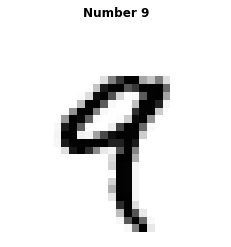

In [227]:
example_id = 4
show_example_plot(mnist.data[example_id],mnist.target[example_id])

In [187]:

# Take two rows
patterns = mnist.data
labels = mnist.target

# We need only the sign (transform to binary input)
patterns = sign(patterns/255.0 - 0.5)

# Set the number of patterns (two in out case)
n_patterns = 2

# Number of units of the network
# n = img_side*img_side

In [317]:
def show_example_plot_binary(example_ids = [0,1]):
    sqrt = np.sqrt(len(example_ids))
    rows = int(np.floor(sqrt))
    cols = int(np.ceil(sqrt))
    
    if rows * cols < len(example_ids):
        rows += 1
    
    fig, axes = plt.subplots(rows, cols,figsize=(12,12))
    ax = axes.ravel()
    for ii, ex_id in enumerate(example_ids):
        ax[ii].imshow(to_mat(patterns[ex_id]),cmap='Greys')
        ax[ii].set(
            title = f'Number {labels[ex_id]}',
        )
    for this_ax in ax:
        this_ax.axis('off')
    plt.tight_layout()

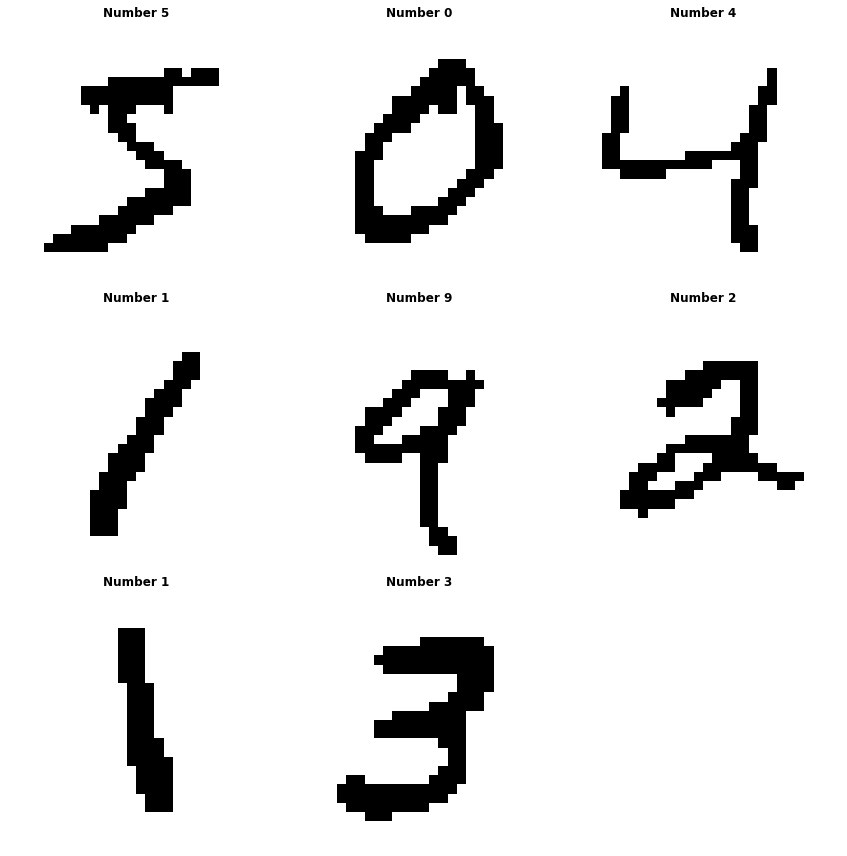

In [320]:
show_example_plot_binary([0,1,2,3,4,5,6,7])

In [205]:
test_network = HopfieldNetwork(
    training_patterns = patterns[[0,1]],
    training_labels = labels[[0,1]])

In [206]:
test_network.train()

MovieWriter Pillow unavailable; using Pillow instead.


simulation finished


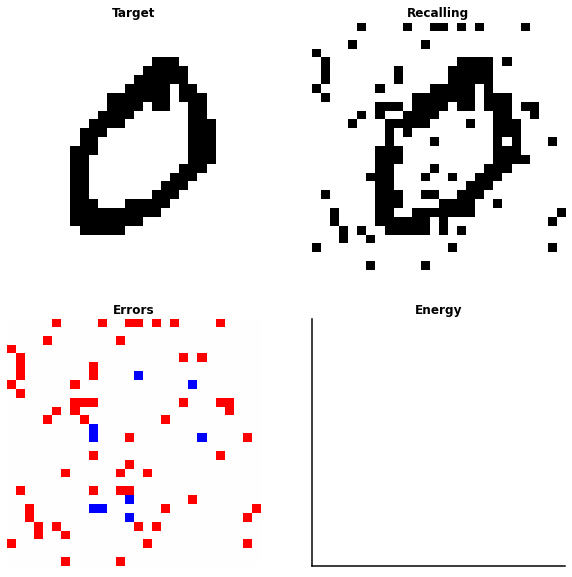

In [207]:
test_network.run_simuation(
    noise=0.1,
    target_pattern=patterns[1],
    target_label=labels[1])

In [214]:
def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Corresponding matrix of eigenvectors
    (numpy array of floats)    : Vector of eigenvalues

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals

def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix

def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors

def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


(7877, 784)
(6990, 784)
(7141, 784)
(6824, 784)
(6313, 784)
(6876, 784)
(7293, 784)
(6825, 784)
(6958, 784)


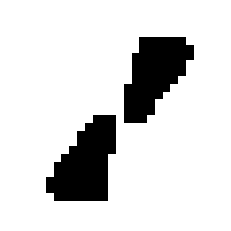

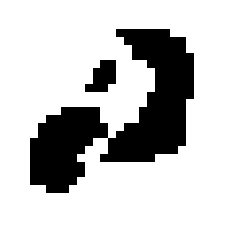

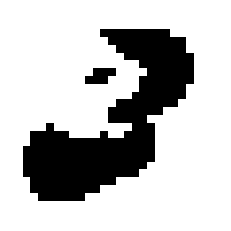

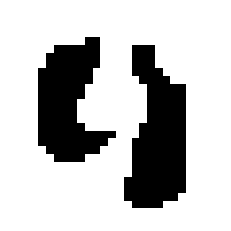

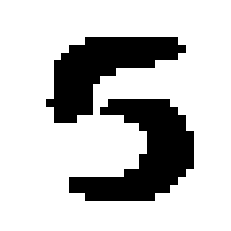

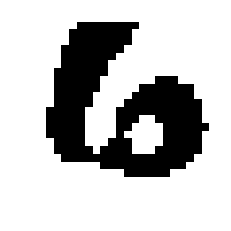

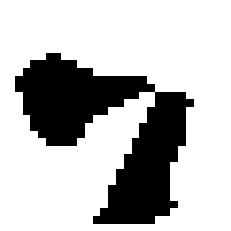

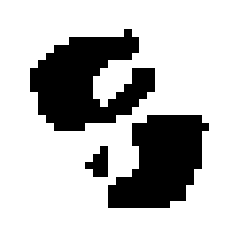

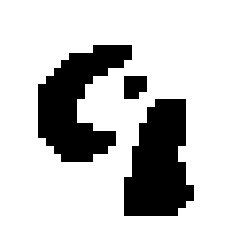

In [312]:


training_data = []
for ii in range(1,10):
    numbers = patterns[labels==f'{ii}']
    print (numbers.shape)
    score, evectors, evals = pca(numbers)
    
    X = evectors[:, 0]
    Y = np.sign(X-np.mean(X))
    if np.sum(Y) > 0:
        Y *= -1
    show_example_plot(Y)
    training_data.append(Y)
    

In [313]:
# The matplotlib object to do animations
from matplotlib import animation
import numpy as np


class HopfieldNetwork(object):
    """docstring for HopfieldNetwork

    patterns: np.array with shape (n_of_patterns, dim_of_patterns)
    """

    def __init__(self, 
        training_patterns,
        training_labels,
        store_overlap_with_training_data=False):
        super(HopfieldNetwork, self).__init__()

        self.training_patterns = training_patterns
        self.training_labels = training_labels

        self.n_training_patterns = self.training_patterns.shape[0]
        self.dim_patterns = self.training_patterns.shape[1]
        self.init_network()

        self.current_target_pattern = self.training_patterns[0]
        self.current_target_label = self.training_labels[0]

        self.store_overlap_with_training_data = store_overlap_with_training_data

    def init_network(self):
        # Initialize weights to zero values
        self.W = zeros([self.dim_patterns, self.dim_patterns])

    def train(self):
        # Accumulate outer products
        for pattern in self.training_patterns:
            self.W += np.outer(pattern, pattern)

        # Divide times the number of patterns
        self.W /= float(self.n_training_patterns)

        # Exclude the autoconnections
        self.W *= 1.0 - eye(self.dim_patterns)

    def run_simuation(
        self,
        noise=0.2,  # 0 = no noise, 1 = only noise
        sim_time=1500,  # timesteps
        frames_to_save=100,
        target_pattern = np.array([]),
        target_label = None,
        save_simulation = True,
        synchrounous_update = False,
    ):
        if target_pattern.size != 0:
            self.current_target_pattern = target_pattern
            self.current_target_label = target_label



        # store data at each sampling interval
        sample_interval = sim_time // frames_to_save

        self.store_images = np.zeros([self.dim_patterns, frames_to_save])
        self.store_energy = np.zeros(frames_to_save)

        x = self.current_target_pattern.copy()

        # We randomly perturb the initial image by swapping the values
        mask = np.sign(np.random.random(self.dim_patterns) - noise)
        random_array = np.sign(np.random.random(self.dim_patterns)-0.5)
        x[mask == -1] = random_array[mask == -1]

        # During the iterations we ranomly select a unit to update
        x_indices = np.arange(self.dim_patterns)
        np.random.shuffle(x_indices)


        # the iterations
        for tt in range(sim_time):

            if synchrounous_update:
                x = sign(np.dot(self.W,x))
            else:
                # get a random index 
                current_x = x_indices[tt % self.dim_patterns]
                # Activation of a unit
                x[current_x] = sign(np.dot(self.W[current_x, :], x))


            # Store current activations
            if sim_time % sample_interval == 0:
                # Energy of the current state of the network
                self.store_energy[tt // sample_interval] = -0.5 * np.dot(x, np.dot(self.W, x))

                # array containing frames_to_save of network activation
                self.store_images[:, tt // sample_interval] = x


                if self.store_overlap_with_training_data:
                    print (np.sum(self.training_patterns == x,axis=1)/self.training_patterns.shape[1])
                    # self.overlap_with_training_data[tt//sample_interval] = a


        print ('simulation finished')

        if save_simulation:
            self.save_simulation()

    def init_figure(self):

        fig, ax = plt.subplots(2,2, figsize=(10,10))

        # Plot 1 - showing the target digit
        # Create subplot
        ax1 = ax[0,0]
        ax1.set_title("Target")
        # Create the imshow and save the handler
        im_target = display_image(ax1, self.current_target_pattern) 

        # Plot 2 - plot the state of the network

        # Create subplot
        ax2 = ax[0,1]
        ax2.set_title("Recalling")

        # Create the imshow and save the handler
        im_activation = display_image(ax2, self.store_images[:,0]) 


        # Plot 3 - plot the history of the energy
        # Create subplot
        ax3 = ax[1,1]

        ax3.set_title("Energy")

        # Create the line plot and save the handler
        im_energy, = ax3.plot(self.store_energy) # the comma after im_energy is important (line plots are returned in lists)

        # style
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.set_xticks([])
        ax3.set_yticks([])   


        ax4 = ax[1,0]
        ax4.set_title("Errors")

        # Create the imshow and save the handler
        im_errors = display_image(ax4, self.store_images[:,0]+ self.current_target_pattern * -1, cmap='bwr') 
        
        # return plot handlers
        return fig, im_target, im_activation, im_energy, im_errors


    def save_simulation(self):

    
        fig, im_target, im_activation, im_energy, im_errors = self.init_figure()
        
        frames = [t for t in range(self.store_images.shape[1])]

        def update(t,
            im_activation=im_activation, 
            im_energy=im_energy,
            im_errors=im_errors,) :
            
            
            A = np.squeeze(self.store_images[:,t])
            im_activation.set_array(to_mat(A))
            im_errors.set_array(to_mat(A + self.current_target_pattern*-1)) 
            im_energy.set_data(np.arange(t), self.store_energy[:t]) 


        # Create and render the animation
        anim = animation.FuncAnimation(fig, func = update,  frames = frames )
        # save it to file
        anim.save(f"mnist-hopfield_{self.current_target_label}.gif",
                  fps = 10, writer='imagemagick',dpi=50)



def to_mat(pattern):
    return pattern.reshape(28,28)

def display_image(ax, img_array,cmap=cm.binary):
    im = ax.imshow(to_mat(img_array), 
                interpolation = 'none', 
                aspect = 'auto',
                cmap = cmap) 
    ax.axis('off')
    return im

In [314]:
test_network = HopfieldNetwork(
    training_patterns = np.array(training_data),
    training_labels = range(1,10),
    store_overlap_with_training_data=True,
)
test_network.train()


[0.74744898 0.71045918 0.67602041 0.7244898  0.68877551 0.66836735
 0.71938776 0.67346939 0.71938776]
[0.74744898 0.71045918 0.67602041 0.7244898  0.68877551 0.66836735
 0.71938776 0.67346939 0.71938776]
[0.74744898 0.71045918 0.67602041 0.7244898  0.68877551 0.66836735
 0.71938776 0.67346939 0.71938776]
[0.74744898 0.71045918 0.67602041 0.7244898  0.68877551 0.66836735
 0.71938776 0.67346939 0.71938776]
[0.74744898 0.71045918 0.67602041 0.7244898  0.68877551 0.66836735
 0.71938776 0.67346939 0.71938776]
[0.74744898 0.71045918 0.67602041 0.7244898  0.68877551 0.66836735
 0.71938776 0.67346939 0.71938776]
[0.74744898 0.71045918 0.67602041 0.7244898  0.68877551 0.66836735
 0.71938776 0.67346939 0.71938776]
[0.74872449 0.71173469 0.67729592 0.72576531 0.69005102 0.66709184
 0.72066327 0.6747449  0.72066327]
[0.74872449 0.71173469 0.67729592 0.72576531 0.69005102 0.66709184
 0.72066327 0.6747449  0.72066327]
[0.74872449 0.71173469 0.67729592 0.72576531 0.69005102 0.66709184
 0.72066327 0.6

[0.71938776 0.73341837 0.68112245 0.7755102  0.7244898  0.72193878
 0.74234694 0.69132653 0.7627551 ]
[0.71938776 0.73341837 0.68112245 0.7755102  0.7244898  0.72193878
 0.74234694 0.69132653 0.7627551 ]
[0.71938776 0.73341837 0.68112245 0.7755102  0.7244898  0.72193878
 0.74234694 0.69132653 0.7627551 ]
[0.71938776 0.73341837 0.68112245 0.7755102  0.7244898  0.72193878
 0.74234694 0.69132653 0.7627551 ]
[0.72066327 0.73469388 0.68239796 0.77423469 0.72576531 0.72321429
 0.74107143 0.69005102 0.76403061]
[0.72066327 0.73469388 0.68239796 0.77423469 0.72576531 0.72321429
 0.74107143 0.69005102 0.76403061]
[0.72193878 0.73596939 0.68367347 0.7755102  0.72704082 0.72193878
 0.73979592 0.68877551 0.7627551 ]
[0.72193878 0.73596939 0.68367347 0.7755102  0.72704082 0.72193878
 0.73979592 0.68877551 0.7627551 ]
[0.72193878 0.73596939 0.68367347 0.7755102  0.72704082 0.72193878
 0.73979592 0.68877551 0.7627551 ]
[0.72321429 0.73469388 0.68494898 0.77423469 0.72831633 0.72321429
 0.73852041 0.6

[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7372449  0.83673469]
[0.71428571 0.76658163 0.68877551 0.8494898  0.79591837 0.78316327
 0.78826531 0.7

[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.78826531 0.9005102 ]
[0.68877551 0.76403061 0.67857143 0.91836735 0.82397959 0.82653061
 0.82142857 0.7

[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.90688776]
[0.66964286 0.74744898 0.65943878 0.93239796 0.8252551  0.8252551
 0.82015306 0.80484694 0.

MovieWriter imagemagick unavailable; using Pillow instead.


[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.81887755 0.91836735]
[0.65306122 0.73341837 0.64285714 0.93367347 0.82653061 0.82142857
 0.82653061 0.8

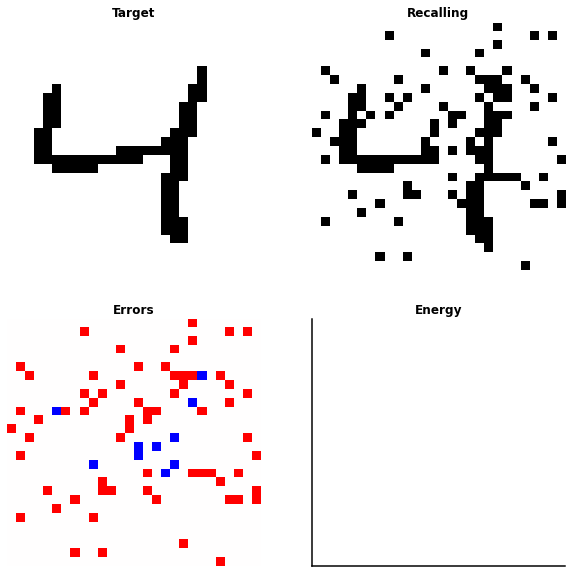

In [315]:
test_network.run_simuation(
    noise=0.2,
    target_pattern=patterns[2],
    target_label=labels[2],
    synchrounous_update=False)